# target encoder & ohe & AFM

In [2]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, afm, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [4]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [5]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [6]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:18, 33158.85it/s]


In [7]:
ecd.fit(test_df, verbose=1)

400000it [00:12, 33106.89it/s]


In [8]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:19, 30278.22it/s]
400000it [00:12, 30856.95it/s]


# Search Max LR

In [19]:
%%time

batch_size = 8192
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False}

mf = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = afm(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 23s 47us/sample - loss: 0.6930 - AUC: 0.5000 - val_loss: 0.6926 - val_AUC: 0.5000
Epoch 2/5
479999/479999 [==============================] - 6s 12us/sample - loss: 0.6915 - AUC: 0.4995 - val_loss: 0.6893 - val_AUC: 0.5000
Epoch 3/5
479999/479999 [==============================] - 6s 12us/sample - loss: 0.6816 - AUC: 0.5001 - val_loss: 0.6653 - val_AUC: 0.5069
Epoch 4/5
479999/479999 [==============================] - 6s 12us/sample - loss: 0.5646 - AUC: 0.5157 - val_loss: 0.4536 - val_AUC: 0.7232
Epoch 5/5
479999/479999 [==============================] - 6s 12us/sample - loss: 0.4191 - AUC: 0.7522 - val_loss: 0.4056 - val_AUC: 0.7746
folds 0 is done, score is 0.7746802714546336
Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 25s 52us/sample - loss: 0.6926 - AUC: 0.5000 - val_loss: 0.6917 - val_AUC: 0.5000
Epoch 2/5

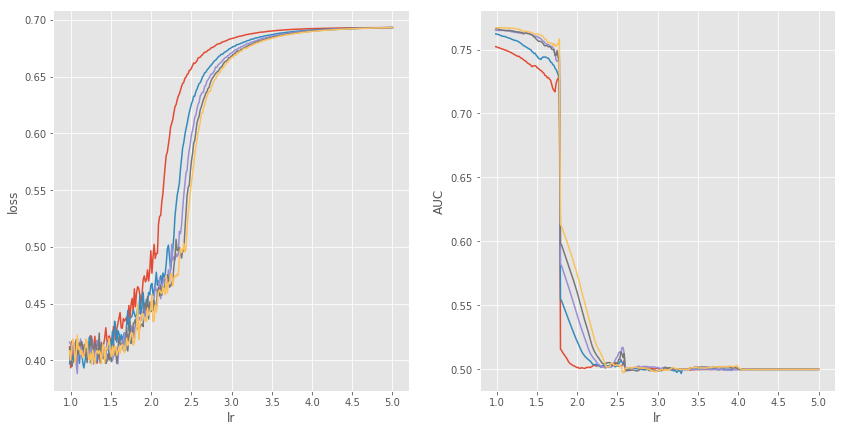

In [20]:
%matplotlib inline
mf.plot(True)

# fit one

In [ ]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False, 
               'k':5,
               'num_att':4}

clr = CyclicLR(base_lr=0.1**(2.5),
               max_lr = 0.1**(1.5), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=2, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = afm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

In [ ]:
score

In [ ]:
tf.keras.backend.clear_session()

# Tuning

In [9]:
tf.keras.backend.clear_session()

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False,
                   'k': 5,
                   'num_att': 4}

ss = {
    'loss': (hp.choice, ('binary_crossentropy', 'focal_loss')), 
    'l2_em': (hp.loguniform, (-20, 0)),
    'afm_l2': (hp.loguniform, (-20, 0))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=afm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=50)

new best, eval 1, score -0.5031, param {'afm_l2': 4.703373697338226e-09, 'l2_em': 0.13593499908512632, 'loss': 'focal_loss'}
new best, eval 2, score -0.7839, param {'afm_l2': 7.424763275365183e-07, 'l2_em': 1.9163994635414696e-05, 'loss': 'binary_crossentropy'}
new best, eval 14, score -0.787, param {'afm_l2': 0.00030346065656407256, 'l2_em': 2.8835327092997467e-06, 'loss': 'binary_crossentropy'}
new best, eval 21, score -0.7879, param {'afm_l2': 0.884330297597194, 'l2_em': 4.4501871933301975e-07, 'loss': 'binary_crossentropy'}
new best, eval 22, score -0.788, param {'afm_l2': 0.7703733390799087, 'l2_em': 2.039261120345864e-07, 'loss': 'binary_crossentropy'}
100%|██████████| 50/50 [6:53:08<00:00, 774.16s/trial, best loss: -0.7879874672110401]   


{'afm_l2': 0.7703733390799087, 'l2_em': 2.039261120345864e-07, 'loss': 0}

In [10]:
log = tuning.log.get_log()

In [11]:
log.sort_values('score').head(20)

,score,update,usetime,afm_l2,l2_em,loss
21,-0.787987,True,577.783756,7.703733e-01,2.039261e-07,binary_crossentropy
20,-0.787934,True,362.092810,8.843303e-01,4.450187e-07,binary_crossentropy
23,-0.787789,False,330.105177,7.189167e-01,2.044892e-07,binary_crossentropy
25,-0.787771,False,346.867788,3.219438e-01,3.523273e-07,binary_crossentropy
34,-0.787683,False,310.749970,7.525837e-03,2.633690e-08,focal_loss
41,-0.787669,False,336.880537,1.493736e-01,6.151198e-08,focal_loss
45,-0.787583,False,353.513679,8.892354e-02,2.360031e-07,binary_crossentropy
40,-0.787561,False,322.784478,2.853694e-02,6.430618e-09,binary_crossentropy
43,-0.787467,False,640.393803,3.210780e-01,6.509325e-06,binary_crossentropy
22,-0.787460,False,341.455029,8.354565e-01,1.055873e-07,binary_crossentropy


In [12]:
log.sort_values('score').tail(20)

,score,update,usetime,afm_l2,l2_em,loss
49,-0.782421,False,1523.787790,1.065423e-06,0.000039,binary_crossentropy
8,-0.779456,False,1103.999957,1.056031e-01,0.000061,binary_crossentropy
9,-0.775993,False,1135.755038,7.881438e-03,0.000022,focal_loss
36,-0.771591,False,750.950894,1.594538e-03,0.000123,binary_crossentropy
39,-0.761675,False,1864.374729,4.613953e-03,0.000161,binary_crossentropy
6,-0.718226,False,924.608256,1.273723e-01,0.000362,binary_crossentropy
4,-0.578118,False,293.361139,3.387613e-07,0.002730,binary_crossentropy
18,-0.528252,False,262.566241,5.401408e-06,0.001016,focal_loss
11,-0.522325,False,207.810828,1.009775e-08,0.001035,focal_loss
46,-0.510993,False,192.170575,1.511028e-04,0.000449,binary_crossentropy


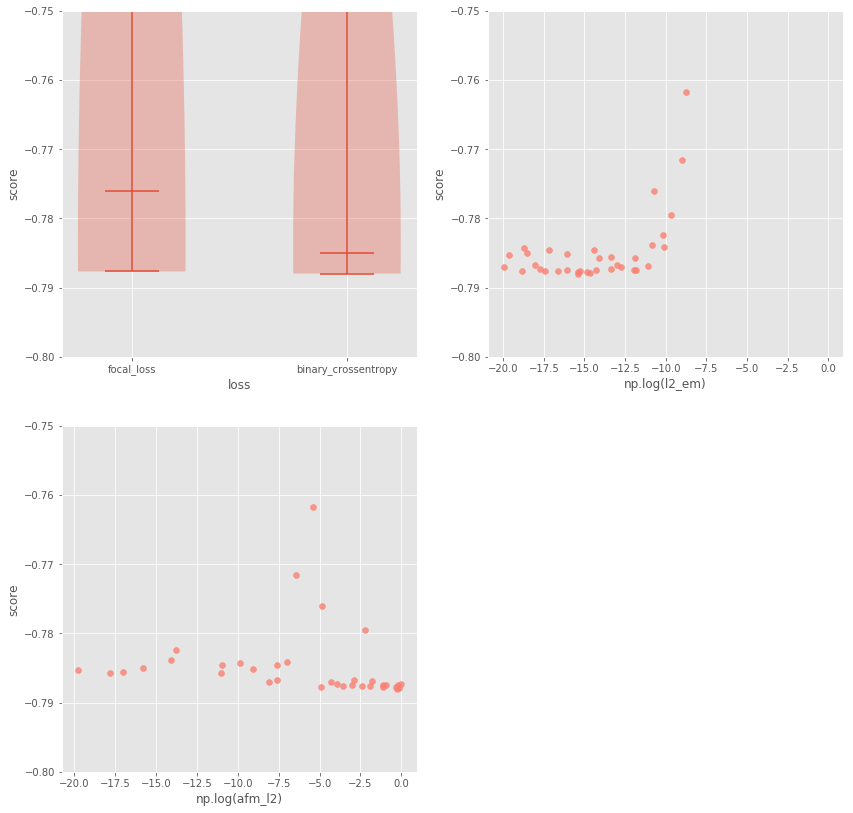

In [13]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.8, -0.75])

# Tuning 2

In [17]:
tf.keras.backend.clear_session()

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False,
                   'k': 5,
                   'num_att': 4, 
                   'loss': 'binary_crossentropy'}

ss = {
    'l2_em': (hp.loguniform, (-20, -12.5)),
    'afm_l2': (hp.loguniform, (-5, 2))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=afm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=50)

new best, eval 1, score -0.7866, param {'afm_l2': 0.016589002229958953, 'l2_em': 4.440223428774073e-09}
new best, eval 3, score -0.7872, param {'afm_l2': 0.027722357769695623, 'l2_em': 6.804089008795961e-07}
new best, eval 21, score -0.7876, param {'afm_l2': 0.007532590354233293, 'l2_em': 6.100329142392466e-07}
new best, eval 27, score -0.7877, param {'afm_l2': 0.06621215980426902, 'l2_em': 1.236716549528052e-06}
100%|██████████| 50/50 [3:52:07<00:00, 275.05s/trial, best loss: -0.7877180648417911]  


{'afm_l2': 0.06621215980426902, 'l2_em': 1.236716549528052e-06}

In [18]:
seed = np.random.randint(2**32)
print(seed)

1372484291


### 1372484291

In [23]:
######
! mkdir ../tmp/afm
log.to_csv(f'../tmp/afm/{seed}.csv', index=False)
#####

In [9]:
seed = 1372484291
log = pd.read_csv(f'../tmp/afm/{seed}.csv')

In [11]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [12]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'use_linear': False,
                   'k': 5,
                   'num_att': 4, 
                   'loss': 'binary_crossentropy'}

In [13]:
# callbacks
clr = CyclicLR(
    base_lr=0.1**(3.5),
    max_lr = 0.1**(2), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [15]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = afm(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    del model, cv
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.7865717144414887
folds 1 is done, score is 0.7859791864638317
folds 2 is done, score is 0.7834873716279412
folds 3 is done, score is 0.7918615979793391
folds 4 is done, score is 0.7867136850281535
folds 5 is done, score is 0.7881301829792644
folds 6 is done, score is 0.7804725969249837
folds 7 is done, score is 0.7962855909203925
folds 8 is done, score is 0.782198002660191
folds 9 is done, score is 0.7842521788141866
folds 10 is done, score is 0.7899268751261862
folds 11 is done, score is 0.784218529174238
folds 12 is done, score is 0.7835741765419014
folds 13 is done, score is 0.7913242991060413
folds 14 is done, score is 0.7948977039261653
folds 15 is done, score is 0.7925015691481408
folds 16 is done, score is 0.7944011818734997
folds 17 is done, score is 0.788732444351908
folds 18 is done, score is 0.7863614153599389
folds 19 is done, score is 0.7867926974205681
folds 20 is done, score is 0.7841623003922052
folds 21 is done, score is 0.7862750859234209
f

folds 20 is done, score is 0.7844123505161481
folds 21 is done, score is 0.7860809140644277
folds 22 is done, score is 0.7820110310062737
folds 23 is done, score is 0.7894267456685435
folds 24 is done, score is 0.7900646575494837
folds 25 is done, score is 0.7902545209693339
folds 26 is done, score is 0.7880585022358316
folds 27 is done, score is 0.7934214282075585
folds 28 is done, score is 0.784647766551884
folds 29 is done, score is 0.7892248040142151
folds 30 is done, score is 0.7909118135239772
folds 31 is done, score is 0.791181886936275
folds 32 is done, score is 0.7820877650376502
folds 33 is done, score is 0.7966195022563952
folds 34 is done, score is 0.7861069545627042
folds 35 is done, score is 0.7814509923372293
folds 36 is done, score is 0.7853809606598321
folds 37 is done, score is 0.7991850860975624
folds 38 is done, score is 0.7931865603764956
folds 39 is done, score is 0.7879916463759051
score:  0.7881545027613065


In [1]:
(0.7882804865672801+0.7881545027613065+0.7878988120357813+0.7879946375541029+0.7885487205119182) / 5

0.7881754318860779

In [17]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save(f'../tmp/afm/{seed}stacking1.npy', pred_arr)
pred_arr.shape

(600000, 5)

In [18]:
pred = np.array(pred_lst).squeeze().T
np.save(f'../tmp/afm/{seed}predict.npy', pred)
pred.shape

(400000, 5)

In [ ]:
! mkdir ../tmp/submission

In [20]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv(f'/data/main_6_afm_{seed}.csv')